In [12]:
#import data
import numpy as np
import pandas as pd
CombinedDataFrame = pd.read_csv("CombinedDataFrame.csv",index_col=["symbol","date"],parse_dates=["date"])

In [15]:
CombinedDataFrame.describe()

,deferredIncomeTax,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,netCashProvidedByOperatingActivities,acquisitionsNet,otherInvestingActivites,commonStockIssued,commonStockRepurchased,effectOfForexChangesOnCash,...,intangibleAssets,longTermInvestments,taxAssets,accountPayables,longTermDebt,deferredRevenueNonCurrent,otherNonCurrentLiabilities,commonStock,totalDebt,is_above_market_average
count,430057.000000,430057.000000,430057.000000,430057.000000,430057.000000,430057.00000,430057.000000,430057.000000,430057.000000,430057.000000,...,430057.000000,430057.000000,430057.000000,430057.000000,430057.000000,430057.000000,430057.000000,430057.000000,430057.000000,430057.000000
mean,880.259842,491.140672,2299.106035,906.217639,2381.315051,579.59361,1826.333102,336.959364,967.031959,870.554333,...,726.824574,381.507509,234.996975,1742.736498,1229.518331,36.702670,1549.195279,1243.181264,1745.609861,0.498908
std,334.841560,634.403386,1272.027204,287.708273,1377.066774,122.52303,848.076355,417.983060,270.941076,308.362318,...,878.583678,505.292430,428.730690,1336.956245,1157.685458,113.785614,1141.413910,1078.506532,1341.493777,0.499999
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,849.000000,56.000000,1250.000000,937.000000,1236.000000,615.00000,1233.000000,100.000000,1089.000000,876.000000,...,3.000000,83.000000,1.000000,455.000000,1.000000,1.000000,425.000000,198.000000,439.000000,0.000000
50%,849.000000,56.000000,2362.000000,937.000000,2323.000000,615.00000,2057.000000,100.000000,1089.000000,876.000000,...,205.000000,83.000000,1.000000,1666.000000,1010.000000,1.000000,1299.000000,1070.000000,1674.000000,0.000000
75%,849.000000,913.000000,3341.000000,937.000000,3573.000000,615.00000,2291.000000,441.000000,1089.000000,876.000000,...,1442.000000,562.000000,281.000000,2916.000000,2244.000000,1.000000,2549.000000,2154.000000,2923.000000,1.000000
max,1853.000000,2066.000000,4588.000000,1692.000000,4822.000000,803.00000,3443.000000,1581.000000,1136.000000,1718.000000,...,2691.000000,1811.000000,1530.000000,4165.000000,3493.000000,598.000000,3798.000000,3386.000000,4172.000000,1.000000


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(CombinedDataFrame.drop(columns="is_above_market_average"), 
                                                    CombinedDataFrame["is_above_market_average"],test_size=0.10, 
                                                    random_state=1)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(X_train, y_train)
# knn_pred = knn.predict(X_test)
# print (f" Accuracy for k-nn is {accuracy_score(y_test, knn_pred)}")

 Accuracy for k-nn is 0.5205087662186672


# LSTM Classifier

In [56]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('CombinedDataFrame.csv',index_col=["symbol","date"],parse_dates=["date"])
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[32]], axis=1, inplace=True)
print(reframed.head())
reframed.info()

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.996762   0.994676   0.010462   0.553783   0.992325   0.367372   
2   0.998381   0.995160   0.675894   0.553783   0.994192   0.083437   
3   0.894226   0.995644   0.976242   0.553783   0.994400   0.112080   
4   0.010793   0.993708   0.058631   0.553783   0.990458   0.115816   
5   0.024285   0.994676   0.015693   0.553783   0.990666   0.070984   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var24(t)  var25(t)  \
1   0.012199   0.063251   0.958627    0.157159  ...       1.0  0.919934   
2   0.012199   0.063251   0.958627    0.945285  ...       1.0  0.914964   
3   0.013360   0.063251   0.958627    0.048312  ...       1.0  0.914412   
4   0.009875   0.063251   0.958627    0.075669  ...       1.0  0.908338   
5   0.011037   0.063251   0.958627    0.982538  ...       1.0  0.909994   

   var26(t)  var27(t)  var28(t)  var29(t)  var30(t)  var31(t)  var32(t)  \
1  0.000654  0.985834  0.992843  0.001672  0.99

In [63]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 64) (8760,) (421296, 1, 64) (421296,)


Epoch 1/50
122/122 - 4s - loss: 0.4910 - val_loss: 0.4913 - 4s/epoch - 35ms/step
Epoch 2/50
122/122 - 3s - loss: 0.4729 - val_loss: 0.4926 - 3s/epoch - 27ms/step
Epoch 3/50
122/122 - 4s - loss: 0.4722 - val_loss: 0.4928 - 4s/epoch - 29ms/step
Epoch 4/50
122/122 - 4s - loss: 0.4693 - val_loss: 0.4924 - 4s/epoch - 29ms/step
Epoch 5/50
122/122 - 3s - loss: 0.4682 - val_loss: 0.4920 - 3s/epoch - 27ms/step
Epoch 6/50
122/122 - 3s - loss: 0.4675 - val_loss: 0.4918 - 3s/epoch - 27ms/step
Epoch 7/50
122/122 - 3s - loss: 0.4670 - val_loss: 0.4909 - 3s/epoch - 25ms/step
Epoch 8/50
122/122 - 3s - loss: 0.4664 - val_loss: 0.4906 - 3s/epoch - 26ms/step
Epoch 9/50
122/122 - 3s - loss: 0.4658 - val_loss: 0.4903 - 3s/epoch - 25ms/step
Epoch 10/50
122/122 - 3s - loss: 0.4654 - val_loss: 0.4888 - 3s/epoch - 25ms/step
Epoch 11/50
122/122 - 3s - loss: 0.4652 - val_loss: 0.4888 - 3s/epoch - 26ms/step
Epoch 12/50
122/122 - 3s - loss: 0.4644 - val_loss: 0.4876 - 3s/epoch - 25ms/step
Epoch 13/50
122/122 - 3s 

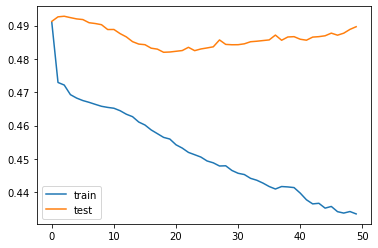

In [64]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [1]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'model' is not defined